"""
decision tree and random forest models with oversampling, with new data added
"""

## Data Processing
### load data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

# load the data
filename = 'data/all_data.csv'
df = pd.read_csv(filename,index_col=0)

filename2 = 'data/sad_new.csv'
df2 = pd.read_csv(filename2,index_col=False)

X1 = df.loc[:,['danceability', 'energy','key','loudness','mode','speechiness',
      'acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']]
X2 = df2.loc[:,['danceability', 'energy','key','loudness','mode','speechiness',
      'acousticness','instrumentalness','liveness','valence','tempo','duration_ms','time_signature']]
Y1 = df.iloc[:, -1]
Y2 = df2.iloc[:, -1]
X = pd.concat([X1, X2])
Y = pd.concat([Y1, Y2])

# change the labels with LabelEncoder() and print the mapping relation
label_mapping = {1:'Sad',2:'Healing',4:'joyful'}

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y = le.fit_transform(Y)

display_labels = [label_mapping[label] for label in le.inverse_transform([0, 1, 2])]
label_mapping_final = [label_mapping[label] for label in le.inverse_transform([0, 1, 2])]
print('Label mapping:',str([0, 1, 2]), '->',label_mapping_final)

Label mapping: [0, 1, 2] -> ['Sad', 'Healing', 'joyful']


### standardization

In [2]:
# standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

### review the data: data shape and class distribution

In [3]:
# data shape
print("The shape (n_samples, n_features) is: ", X_std.shape)

# class distribution
from collections import Counter
counter = Counter(Y)
print(counter)

The shape (n_samples, n_features) is:  (14146, 13)
Counter({1: 9629, 2: 4079, 0: 438})


##  Decision Tree

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X_std,Y,stratify=Y, test_size=0.2, random_state=1)

In [5]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over_sampling_strategy = {0: int(0.3 * len(y_train))}
under_sampling_strategy = {1: int(0.42 * len(y_train)), 2: int(0.28 * len(y_train))}

# define pipeline
over = SMOTE(sampling_strategy=over_sampling_strategy)
under = RandomUnderSampler(sampling_strategy=under_sampling_strategy)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_train, y_train = pipeline.fit_resample(X_train, y_train)
# summarize the new class distribution
counter = Counter(y_train)
print(counter)

Counter({1: 4752, 0: 3394, 2: 3168})


In [6]:
# train the model on train set
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
  
# print prediction results
predictions = model.predict(X_test)
print(classification_report(y_test, predictions, target_names=display_labels))

              precision    recall  f1-score   support

         Sad       0.32      0.50      0.39        88
     Healing       0.96      0.94      0.95      1926
      joyful       0.86      0.84      0.85       816

    accuracy                           0.90      2830
   macro avg       0.71      0.76      0.73      2830
weighted avg       0.91      0.90      0.90      2830



### grid search for the best hyperparameters

In [7]:
from sklearn import decomposition
from sklearn.model_selection import GridSearchCV

dtree = DecisionTreeClassifier()
pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('dec_tree', dtree)])

# n_components = list(range(1,X.shape[1]+1,1))
# criterion = ['gini', 'entropy']
# max_depth = [2,4,6,8,10,12]

n_components = [13]
criterion = ['entropy']
max_depth = [12]

parameters = dict(pca__n_components=n_components,
                      dec_tree__criterion=criterion,
                      dec_tree__max_depth=max_depth)

clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(X_train, y_train)

# print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
# print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])
# print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])

GridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                       ('dec_tree', DecisionTreeClassifier())]),
             param_grid={'dec_tree__criterion': ['entropy'],
                         'dec_tree__max_depth': [12],
                         'pca__n_components': [13]})

In [8]:
# print prediction results
predictions = clf_GS.predict(X_test)
print(classification_report(y_test, predictions, target_names=display_labels))

              precision    recall  f1-score   support

         Sad       0.27      0.60      0.37        88
     Healing       0.95      0.94      0.94      1926
      joyful       0.88      0.78      0.82       816

    accuracy                           0.88      2830
   macro avg       0.70      0.77      0.71      2830
weighted avg       0.91      0.88      0.89      2830



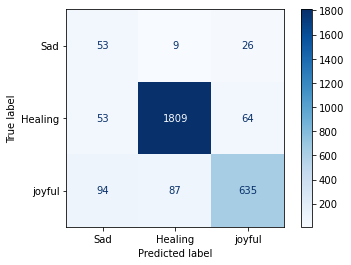

In [9]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

display_labels = [label_mapping[label] for label in le.inverse_transform([0, 1, 2])]
plot_confusion_matrix(clf_GS, X_test, y_test,cmap=plt.cm.Blues, 
                     display_labels=display_labels)  
plt.show() 

## Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

rfc=RandomForestClassifier(random_state=42)
# param_grid2 = { 
#     'n_estimators': [200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,5,6,7,8],
#     'criterion' :['gini', 'entropy']}

param_grid2 = { 
    'n_estimators': [200],
    'max_features': ['auto'],
    'max_depth' : [8],
    'criterion' :['entropy']}


CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid2, cv= 5)
CV_rfc.fit(X_train, y_train)

print(CV_rfc.best_params_)

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 200}


In [11]:
# print prediction results
predictions_rf = CV_rfc.predict(X_test)
print(classification_report(y_test, predictions_rf, target_names=display_labels))

              precision    recall  f1-score   support

         Sad       0.34      0.66      0.45        88
     Healing       0.95      0.97      0.96      1926
      joyful       0.96      0.80      0.87       816

    accuracy                           0.91      2830
   macro avg       0.75      0.81      0.76      2830
weighted avg       0.93      0.91      0.92      2830



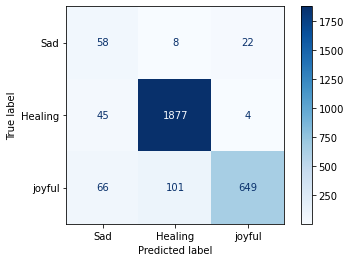

In [12]:
plot_confusion_matrix(CV_rfc, X_test, y_test,cmap=plt.cm.Blues, display_labels=display_labels)  
plt.show() 